[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RatInABox-Lab/RatInABox/blob/main/demos/decoding_position_example.ipynb)

# 从神经元的放电率解码位置
> Decoding position from firing rates 

In this example we show how position can be decoded from neural firing rates. For this you will use  sklearn's linear regression model and compare it to sklearns gaussian process regression model. 
在本例中，我们展示如何从神经元的放电率解码老鼠的位置。你将使用sklearn的线性回归模型，并与sklearn的高斯过程回归模型进行对比。

The plan is as follows. 
1. Initialise a 2D `Environment` an `Agent` and some populations of various types of `Neurons` 
2. Explore the environment for 5 minutes, then train decoders to map firing rates to positions from the "training" data generates.
3. Explore for 1 extra minute. Decode position from this "testing" data. Compare to the true position.
方案如下：
1. 初始化一个二维`Environment`（环境）、一个`Agent`（智能体）以及多种类型的神经元群体。
2. 在环境中探索5分钟，然后用“训练”数据来训练解码器，将放电率映射到位置。
3. 额外探索1分钟。使用“测试”数据进行位置解码，并将解码结果与真实位置进行比较。


In [5]:
# Install dependencies 
%pip install ratinabox
%pip install scikit-learn
%pip install tqdm 

%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#Import ratinabox 
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import PlaceCells, GridCells, BoundaryVectorCells

#stylize plots and set figure directory for saving 
ratinabox.stylize_plots(); ratinabox.autosave_plots=True; ratinabox.figure_directory="../figures/"

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor

## 创建解码器

First make a function `train_decoder()` which takes in a population of `Neurons` and trains two decoders (Gaussian process and linear ridge regression) on firing rate and position data stored in the `Neurons` history dataframe. These decoders are saved back into the class itself, as attributes. 

A second function `decode_position()` takes a population of `Neurons` and decodes position from firing rate data in is history data frame and the decoders we just trained. 

首先，创建一个名为 `train_decoder()` 的函数，该函数接收一个 `Neurons` 神经元群体对象，并基于 `Neurons` 历史数据中的放电率和位置数据分别训练两个解码器（高斯过程回归和线性岭回归）。这些解码器将作为属性被存储回该类对象中。

第二个函数 `decode_position()` 接收一个 `Neurons` 神经元群体对象，并利用历史数据中的放电率以及预先训练好的解码器来对位置进行解码。

In [ ]:
def train_decoder(Neurons, t_start=None, t_end=None):
    """训练解码器：从神经元放电率预测位置
    
    参数:
        Neurons: 神经元群体对象 (PlaceCells/GridCells/BVCs)
        t_start: 训练数据起始时间（秒），None表示从头开始
        t_end: 训练数据结束时间（秒），None表示到最后
    """
    # ========== 1. 提取训练数据 ==========
    # 获取时间戳数组
    t = np.array(Neurons.history["t"])
    
    # 确定数据范围的起始和结束索引
    i_start = (0 if t_start is None else np.argmin(np.abs(t - t_start)))
    i_end = (-1 if t_end is None else np.argmin(np.abs(t - t_end)))
    
    # 数据降采样（每5个点取1个）以减少冗余和加速训练
    t = t[i_start:i_end][::5]
    # 放电率数据：形状为 (时间步数, 神经元数量)
    fr = np.array(Neurons.history["firingrate"])[i_start:i_end][::5]
    # 位置数据：形状为 (时间步数, 2)，表示 (x, y) 坐标
    pos = np.array(Neurons.Agent.history["pos"])[i_start:i_end][::5]
    
    # ========== 2. 初始化并训练解码模型 ==========
    from sklearn.gaussian_process.kernels import RBF
    
    # 模型1: 高斯过程回归 (Gaussian Process Regression)
    # - 非参数贝叶斯模型，能捕捉非线性关系
    # - alpha: 噪声水平，用于正则化
    # - kernel: RBF核函数（径向基函数），衡量输入相似度
    model_GP = GaussianProcessRegressor(
        alpha=0.01,  # 观测噪声方差
        kernel=RBF(
            1 * np.sqrt(Neurons.n / 20),  # 核长度尺度，随神经元数量自适应调整
            length_scale_bounds="fixed",  # 固定长度尺度，不进行优化
        ),
    )
    
    # 模型2: 岭回归 (Ridge Regression / Linear Regression with L2 regularization)
    # - 线性模型，假设位置与放电率成线性关系
    # - alpha: L2正则化强度，防止过拟合
    model_LR = Ridge(alpha=0.01)
    
    # 训练两个模型：输入=放电率(fr)，输出=位置(pos)
    model_GP.fit(fr, pos)  # 拟合高斯过程
    model_LR.fit(fr, pos)  # 拟合岭回归
    
    # ========== 3. 保存模型到神经元对象中 ==========
    Neurons.decoding_model_GP = model_GP  # 高斯过程解码器
    Neurons.decoding_model_LR = model_LR  # 岭回归解码器
    return


def decode_position(Neurons, t_start=None, t_end=None):
    """使用训练好的解码器从放电率预测位置
    
    参数:
        Neurons: 神经元群体对象（需已训练解码器）
        t_start: 解码数据起始时间（秒）
        t_end: 解码数据结束时间（秒）
    
    返回:
        (时间数组, GP预测位置, LR预测位置)
    """
    # ========== 1. 提取测试数据 ==========
    t = np.array(Neurons.history["t"])
    
    # 确定解码范围
    i_start = (0 if t_start is None else np.argmin(np.abs(t - t_start)))
    i_end = (-1 if t_end is None else np.argmin(np.abs(t - t_end)))
    
    # 提取对应时间段的数据（不降采样，保留完整时间分辨率）
    t = t[i_start:i_end]
    fr = np.array(Neurons.history["firingrate"])[i_start:i_end]
    
    # ========== 2. 使用训练好的模型进行位置解码 ==========
    # 高斯过程解码：放电率 → 位置
    decoded_position_GP = Neurons.decoding_model_GP.predict(fr)
    # 岭回归解码：放电率 → 位置
    decoded_position_LR = Neurons.decoding_model_LR.predict(fr)
    
    # 返回时间戳和两种方法的解码结果
    return (t, decoded_position_GP, decoded_position_LR)

## 初始化
Initialise Environment, Agent, and cell populations. We will compare place cells, grid cells and boundary vectory cells. 

In [7]:
np.random.seed(10)  # make reproducible
n = 10

Env = Environment()
Env.add_wall(np.array([[0.4, 0], [0.4, 0.4]]))
Ag = Agent(Env, params={"dt": 50e-3})


PCs = PlaceCells(
    Ag,
    params={"description": "gaussian_threshold", "widths": 0.4, "n": n, "color": "C1"},
)
GCs = GridCells(
    Ag,
    params={"n": n, "color": "C2"},
)
BVCs = BoundaryVectorCells(Ag, params={"n":n, "color": "C3"})

## 创建训练数据
Generate training data (5 minutes of random exploration)...

100%|██████████| 6000/6000 [00:08<00:00, 670.26it/s]


Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\trajectory_1801.png  & .svg


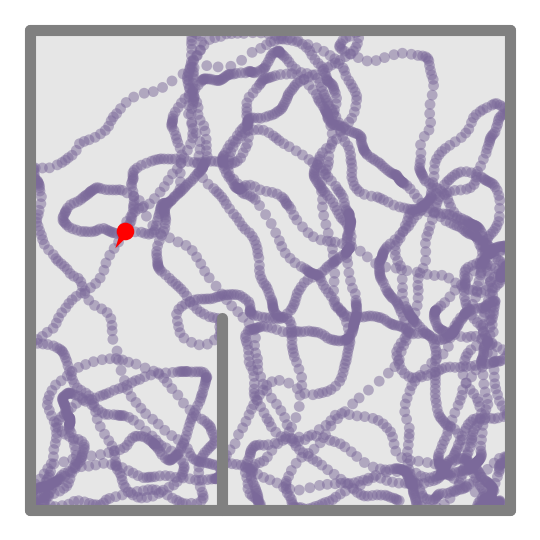

In [8]:
np.random.seed(9)
from tqdm import tqdm

for i in tqdm(range(int(5 * 60 / Ag.dt))):
    Ag.update()
    PCs.update()
    GCs.update()
    BVCs.update()

fig_t, ax_t = Ag.plot_trajectory(alpha=0.5)

Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\trajectory_1801_1.png  & .svg


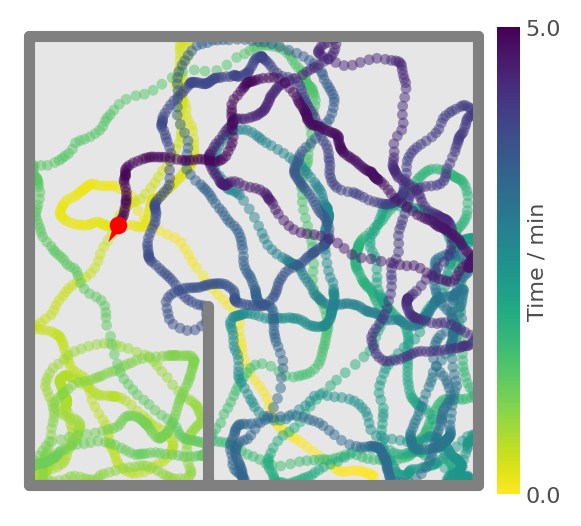

In [9]:
fig_t, ax_t = Ag.plot_trajectory(t_end=5*60, alpha=0.5, color="changing", colorbar=True)

不同细胞可视化

Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\PlaceCells_ratemaps_1802.png  & .svg
Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\GridCells_ratemaps_1802.png  & .svg
Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\BoundaryVectorCells_ratemaps_1802.png  & .svg


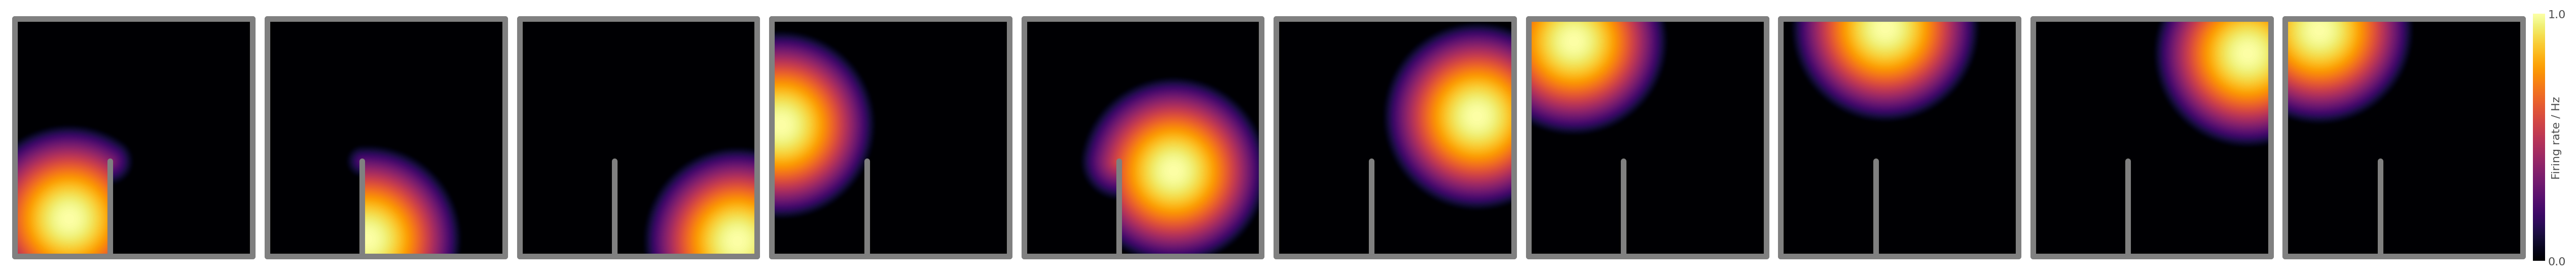

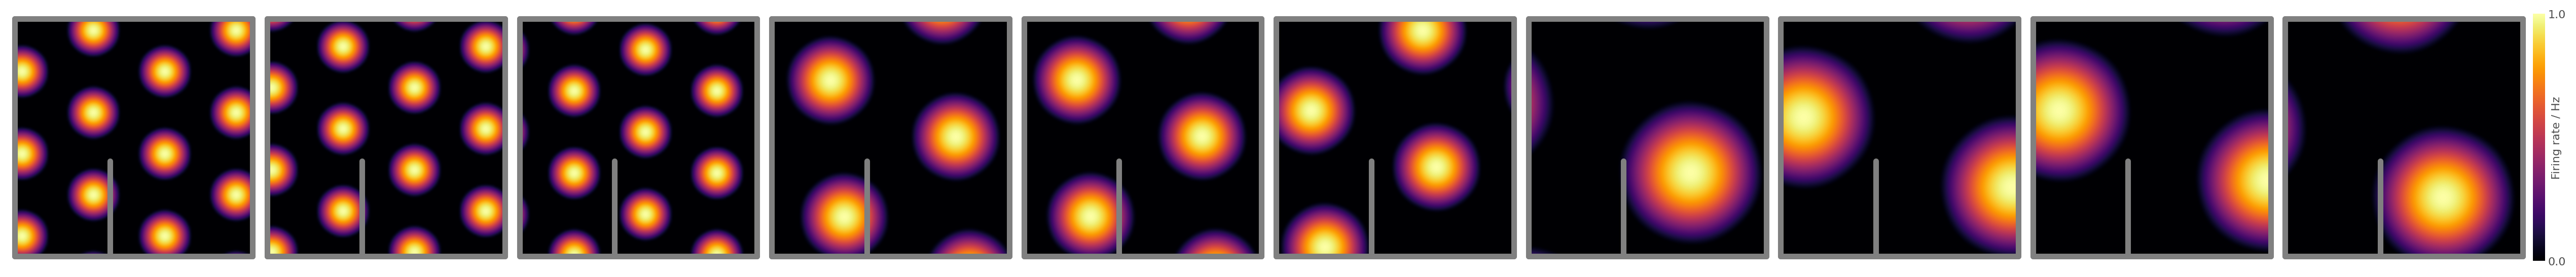

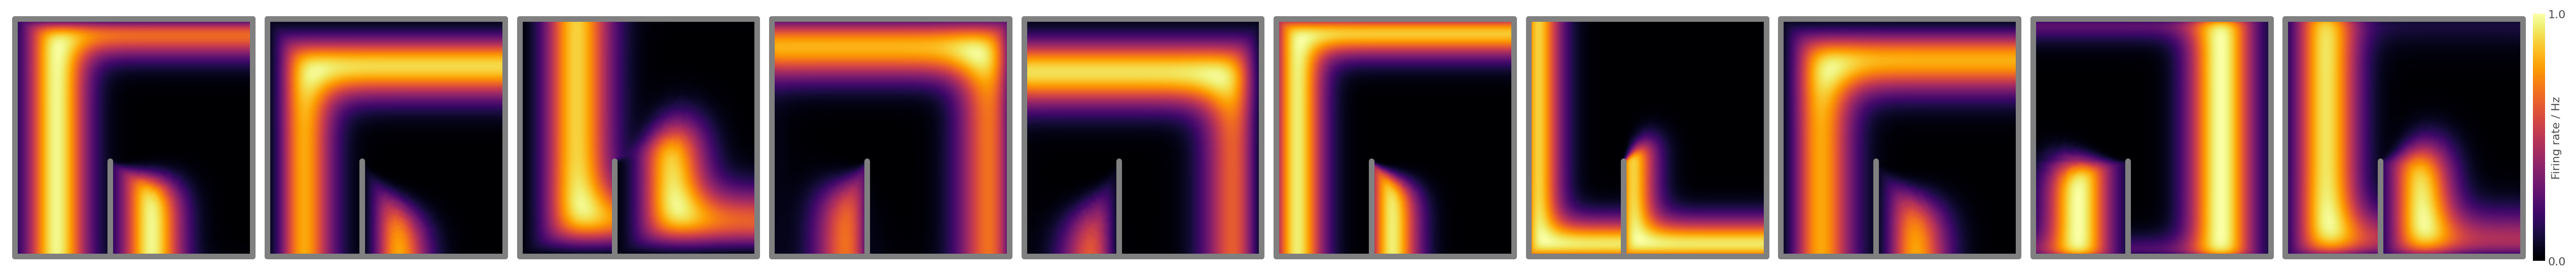

In [10]:
#Plot the rate maps of the different feature types 
fig, ax = PCs.plot_rate_map(chosen_neurons="all")
fig, ax = GCs.plot_rate_map(chosen_neurons="all")
fig, ax = BVCs.plot_rate_map(chosen_neurons="all")

训练解码模型

In [11]:
train_decoder(PCs)
train_decoder(GCs)
train_decoder(BVCs)

Now generate an additional minute of testing data and "decode" position from it.
生成额外一分钟的测试数据，并从中“解码”出位置信息。

In [12]:
np.random.seed(10)
for i in tqdm(range(int(60 / Ag.dt))):
    Ag.update()
    PCs.update()
    GCs.update()
    BVCs.update()

Ag.plot_trajectory(fig=fig_t, ax=ax_t, t_start=Ag.t - 60, color="black", alpha=0.5)

100%|██████████| 1200/1200 [00:01<00:00, 649.51it/s]


Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\trajectory_1802.png  & .svg


(<Figure size 500x500 with 2 Axes>, <Axes: >)

In [13]:
t, pos_PCs_GP, pos_PCs_LR = decode_position(PCs, t_start=Ag.t - 60)
t, pos_GCs_GP, pos_GCs_LR = decode_position(GCs, t_start=Ag.t - 60)
t, pos_BVCs_GP, pos_BVCs_LR = decode_position(BVCs, t_start=Ag.t - 60)

Visualise results: blue is the ground truth (real position) whereas coloured traces are the decodings. Compare the Gaussian process regression to linear regression
可视化结果：黑色代表真实值（实际位置），彩色轨迹为解码结果。比较高斯过程回归与线性回归的效果。

Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\trajectory_1802_1.png  & .svg
Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\trajectory_1802_2.png  & .svg
Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\trajectory_1802_3.png  & .svg
Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\trajectory_1802_4.png  & .svg
Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\trajectory_1802_5.png  & .svg
Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\trajectory_1802_6.png  & .svg


Text(0.5, 1.0, 'Boundary vector cells')

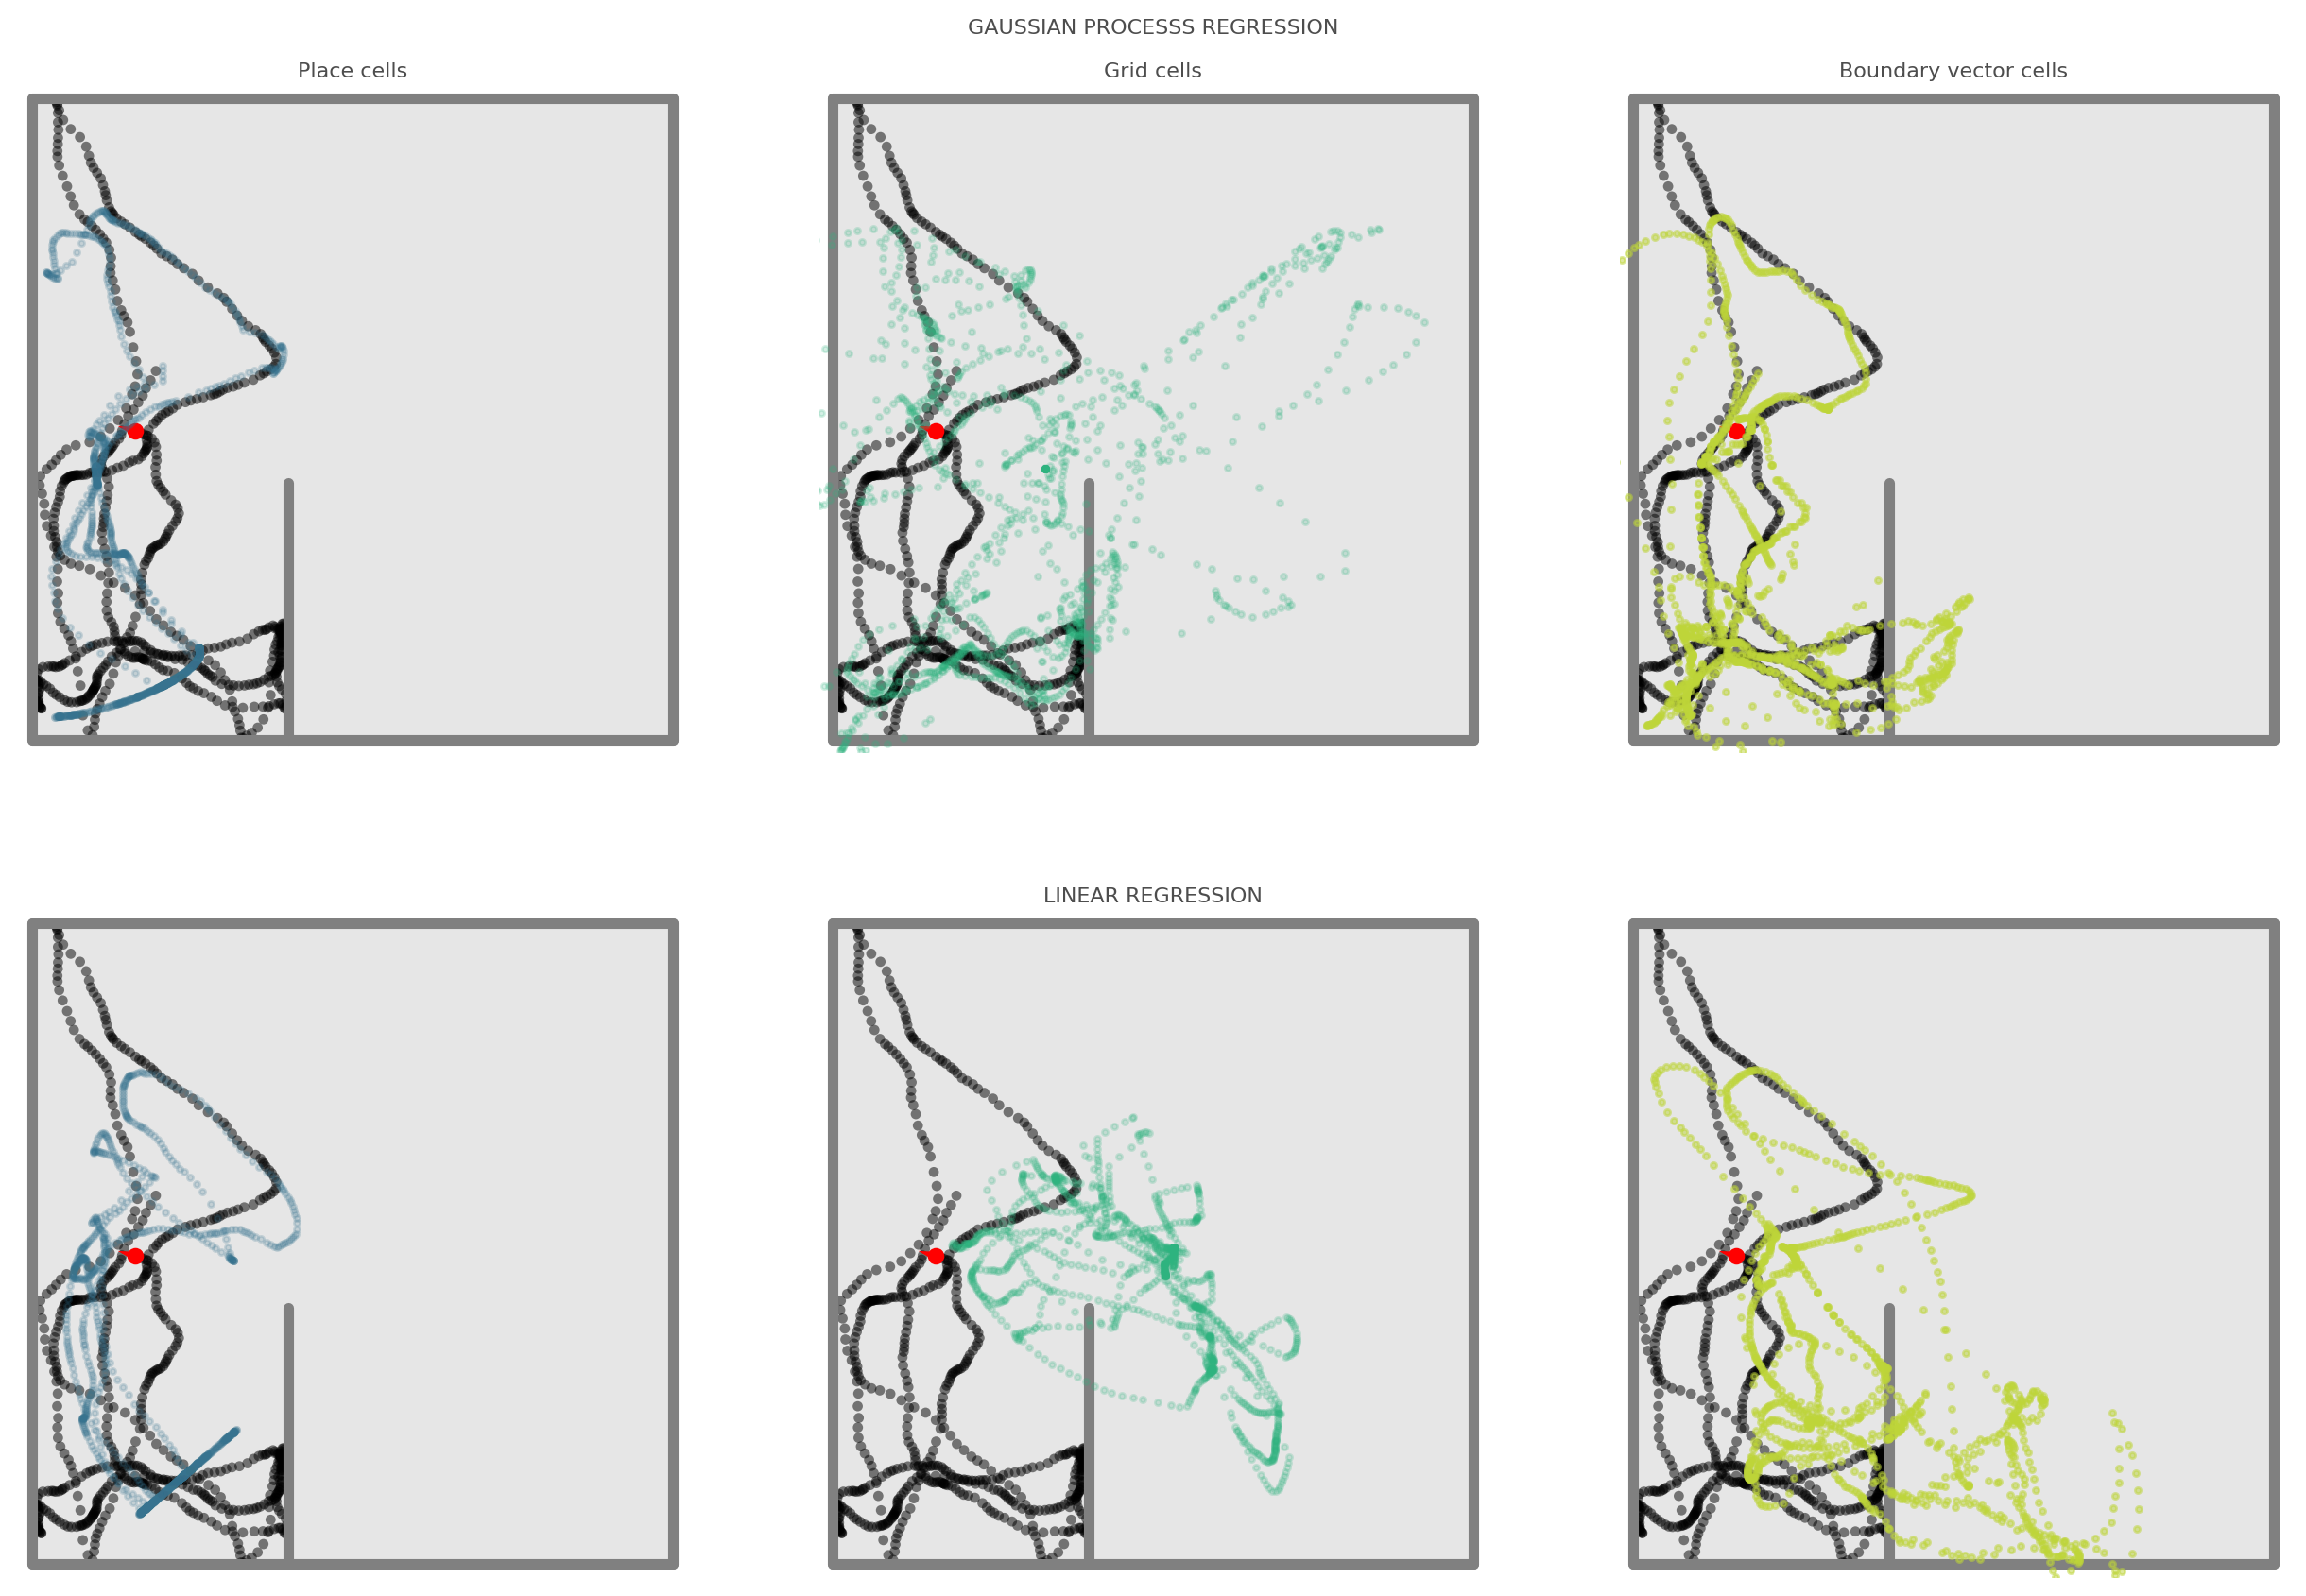

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
Ag.plot_trajectory(t_start=Ag.t - 60, fig=fig, ax=ax[0, 0], color="black", alpha=0.5)
ax[0, 0].scatter(pos_PCs_GP[:, 0], pos_PCs_GP[:, 1], s=5, c="C1", alpha=0.2, zorder=3.1)
Ag.plot_trajectory(t_start=Ag.t - 60, fig=fig, ax=ax[1, 0], color="black", alpha=0.5)
ax[1, 0].scatter(pos_PCs_LR[:, 0], pos_PCs_LR[:, 1], s=5, c="C1", alpha=0.2, zorder=3.1)
ax[0, 0].set_title("Place cells")

Ag.plot_trajectory(t_start=Ag.t - 60, fig=fig, ax=ax[0, 1], color="black", alpha=0.5)
ax[0, 1].scatter(pos_GCs_GP[:, 0], pos_GCs_GP[:, 1], s=5, c="C2", alpha=0.2, zorder=3.1)
Ag.plot_trajectory(t_start=Ag.t - 60, fig=fig, ax=ax[1, 1], color="black", alpha=0.5)
ax[1, 1].scatter(pos_GCs_LR[:, 0], pos_GCs_LR[:, 1], s=5, c="C2", alpha=0.2, zorder=3.1)
ax[0, 1].set_title("GAUSSIAN PROCESSS REGRESSION\n\nGrid cells")
ax[1, 1].set_title("LINEAR REGRESSION")

Ag.plot_trajectory(t_start=Ag.t - 60, fig=fig, ax=ax[0, 2], color="black", alpha=0.5)
ax[0, 2].scatter(
    pos_BVCs_GP[:, 0], pos_BVCs_GP[:, 1], s=5, c="C3", alpha=0.5, zorder=3.1
)
Ag.plot_trajectory(t_start=Ag.t - 60, fig=fig, ax=ax[1, 2], color="black", alpha=0.5)
ax[1, 2].scatter(
    pos_BVCs_LR[:, 0], pos_BVCs_LR[:, 1], s=5, c="C3", alpha=0.5, zorder=3.1
)
ax[0, 2].set_title("Boundary vector cells")

Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\trajectory_1802_7.png  & .svg
Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\BVCs_decoding_GP_1802.png  & .svg


C:\Users\Chihong\AppData\Local\Temp\ipykernel_19596\2937261144.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pos_BVCs_GP[:, 0], pos_BVCs_GP[:, 1], s=15, c=(165/256,56/256,138/256), alpha=0.5, zorder=3.1, linewidth=0)


'../figures/26_01_13\\BVCs_decoding_GP_1802'

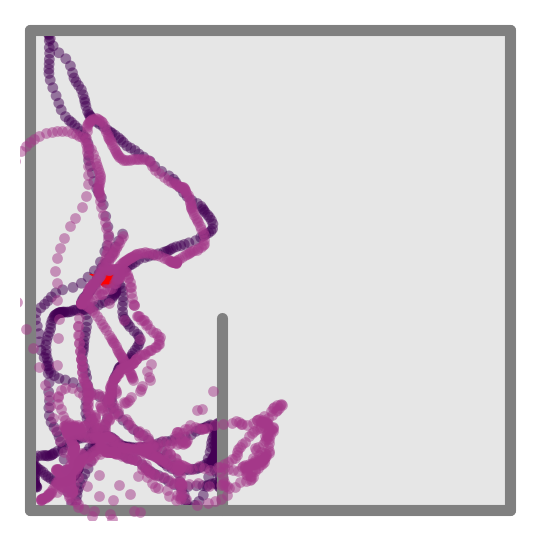

In [15]:
fig, ax = Ag.plot_trajectory(t_start=Ag.t - 60, alpha=0.5,color=matplotlib.colormaps["viridis_r"](256),colorbar=True)
ax.scatter(pos_BVCs_GP[:, 0], pos_BVCs_GP[:, 1], s=15, c=(165/256,56/256,138/256), alpha=0.5, zorder=3.1, linewidth=0)
ratinabox.utils.save_figure(fig, "BVCs_decoding_GP")


Figure saved to f:\__CODE__\251224_RatInABox\RatInABox\figures\26_01_13\BoundaryVectorCells_ratemaps_1802_1.png  & .svg


(<Figure size 500x500 with 2 Axes>, array([<Axes: >], dtype=object))

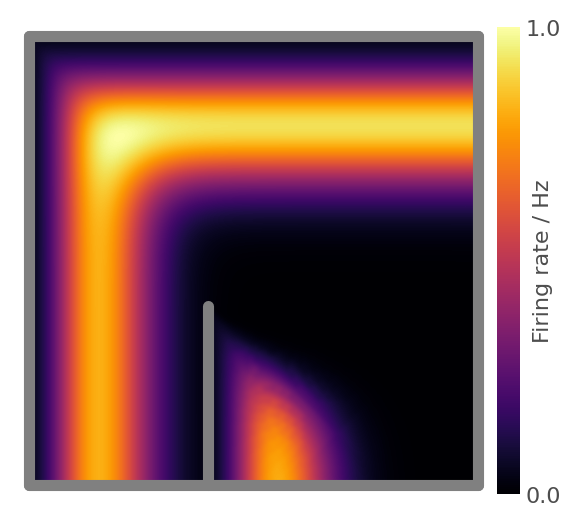

In [16]:
BVCs.plot_rate_map(chosen_neurons=[1])

## 大规模性能基准测试

Make a big loop which repeats the above analysis but for different numbers of basis features. Plot the average error as a function of number of basis features.  
构建一个大循环，重复上述分析但针对不同数量的基特征。将平均误差绘制为基特征数量的函数。

研究神经元数量与位置解码精度的关系：
> "用多少个神经元才能准确解码位置？"

THIS WILL TAKE A LONG TIME TO RUN 

In [2]:
from tqdm.notebook import tqdm  
# notebook compatible loading bars

# 7种不同的神经元数量
N_features = [320, 160, 80, 40, 20, 10, 5]
# 每种条件重复15次
N_repeats = 15


# results_array = np.zeros(shape=(3, 7, 15, 2))
#                                ↑  ↑  ↑   ↑
#                                │  │  │   └─ 2种解码器 (GP, LR)
#                                │  │  └───── 15次重复
#                                │  └──────── 7种神经元数量
#                                └─────────── 3种神经元类型
results_array = np.zeros(shape=(3, len(N_features), N_repeats, 2))

Env = Environment()
Env.add_wall(np.array([[0.4, 0], [0.4, 0.4]]))

for (i, N) in enumerate(tqdm(N_features, desc="Features")):
    for j in tqdm(range(N_repeats), leave=False, desc="Repeats"):
        # Initialise agent and features
        Ag = Agent(Env, params={"dt": 50e-3})
        PCs = PlaceCells(
            Ag, params={"n": N, "description": "gaussian_threshold", "widths": 0.4}
        )
        GCs = GridCells(
            Ag,
            params={"n": N, "gridscale": 0.4},
        )
        BVCs = BoundaryVectorCells(Ag, params={"n": N})

        # Generate training data
        for _ in range(int(5 * 60 / Ag.dt)):
            Ag.update()
            PCs.update()
            GCs.update()
            BVCs.update()

        # Train
        train_decoder(PCs)
        train_decoder(GCs)
        train_decoder(BVCs)

        # Generate test data
        steps = int(1 * 60 / Ag.dt)
        for _ in range(steps):
            Ag.update()
            PCs.update()
            GCs.update()
            BVCs.update()

        # Test
        t, pos_PCs_GP, pos_PCs_LR = decode_position(PCs, t_start=Ag.t - 60)
        t, pos_GCs_GP, pos_GCs_LR = decode_position(GCs, t_start=Ag.t - 60)
        t, pos_BVCs_GP, pos_BVCs_LR = decode_position(BVCs, t_start=Ag.t - 60)
        pos_groundtruth = np.array(Ag.history["pos"])[-steps:, :]

        # Save results (error in cm) for both gaussian process and linear regression
        PC_error_GP = 100 * np.linalg.norm(pos_PCs_GP - pos_groundtruth, axis=1).mean()
        GC_error_GP = 100 * np.linalg.norm(pos_GCs_GP - pos_groundtruth, axis=1).mean()
        BVC_error_GP = (
            100 * np.linalg.norm(pos_BVCs_GP - pos_groundtruth, axis=1).mean()
        )
        PC_error_LR = 100 * np.linalg.norm(pos_PCs_LR - pos_groundtruth, axis=1).mean()
        GC_error_LR = 100 * np.linalg.norm(pos_GCs_LR - pos_groundtruth, axis=1).mean()
        BVC_error_LR = (
            100 * np.linalg.norm(pos_BVCs_LR - pos_groundtruth, axis=1).mean()
        )

        results_array[0, i, j, 0] = PC_error_GP
        results_array[1, i, j, 0] = GC_error_GP
        results_array[2, i, j, 0] = BVC_error_GP
        results_array[0, i, j, 1] = PC_error_LR
        results_array[1, i, j, 1] = GC_error_LR
        results_array[2, i, j, 1] = BVC_error_LR

NameError: name 'np' is not defined

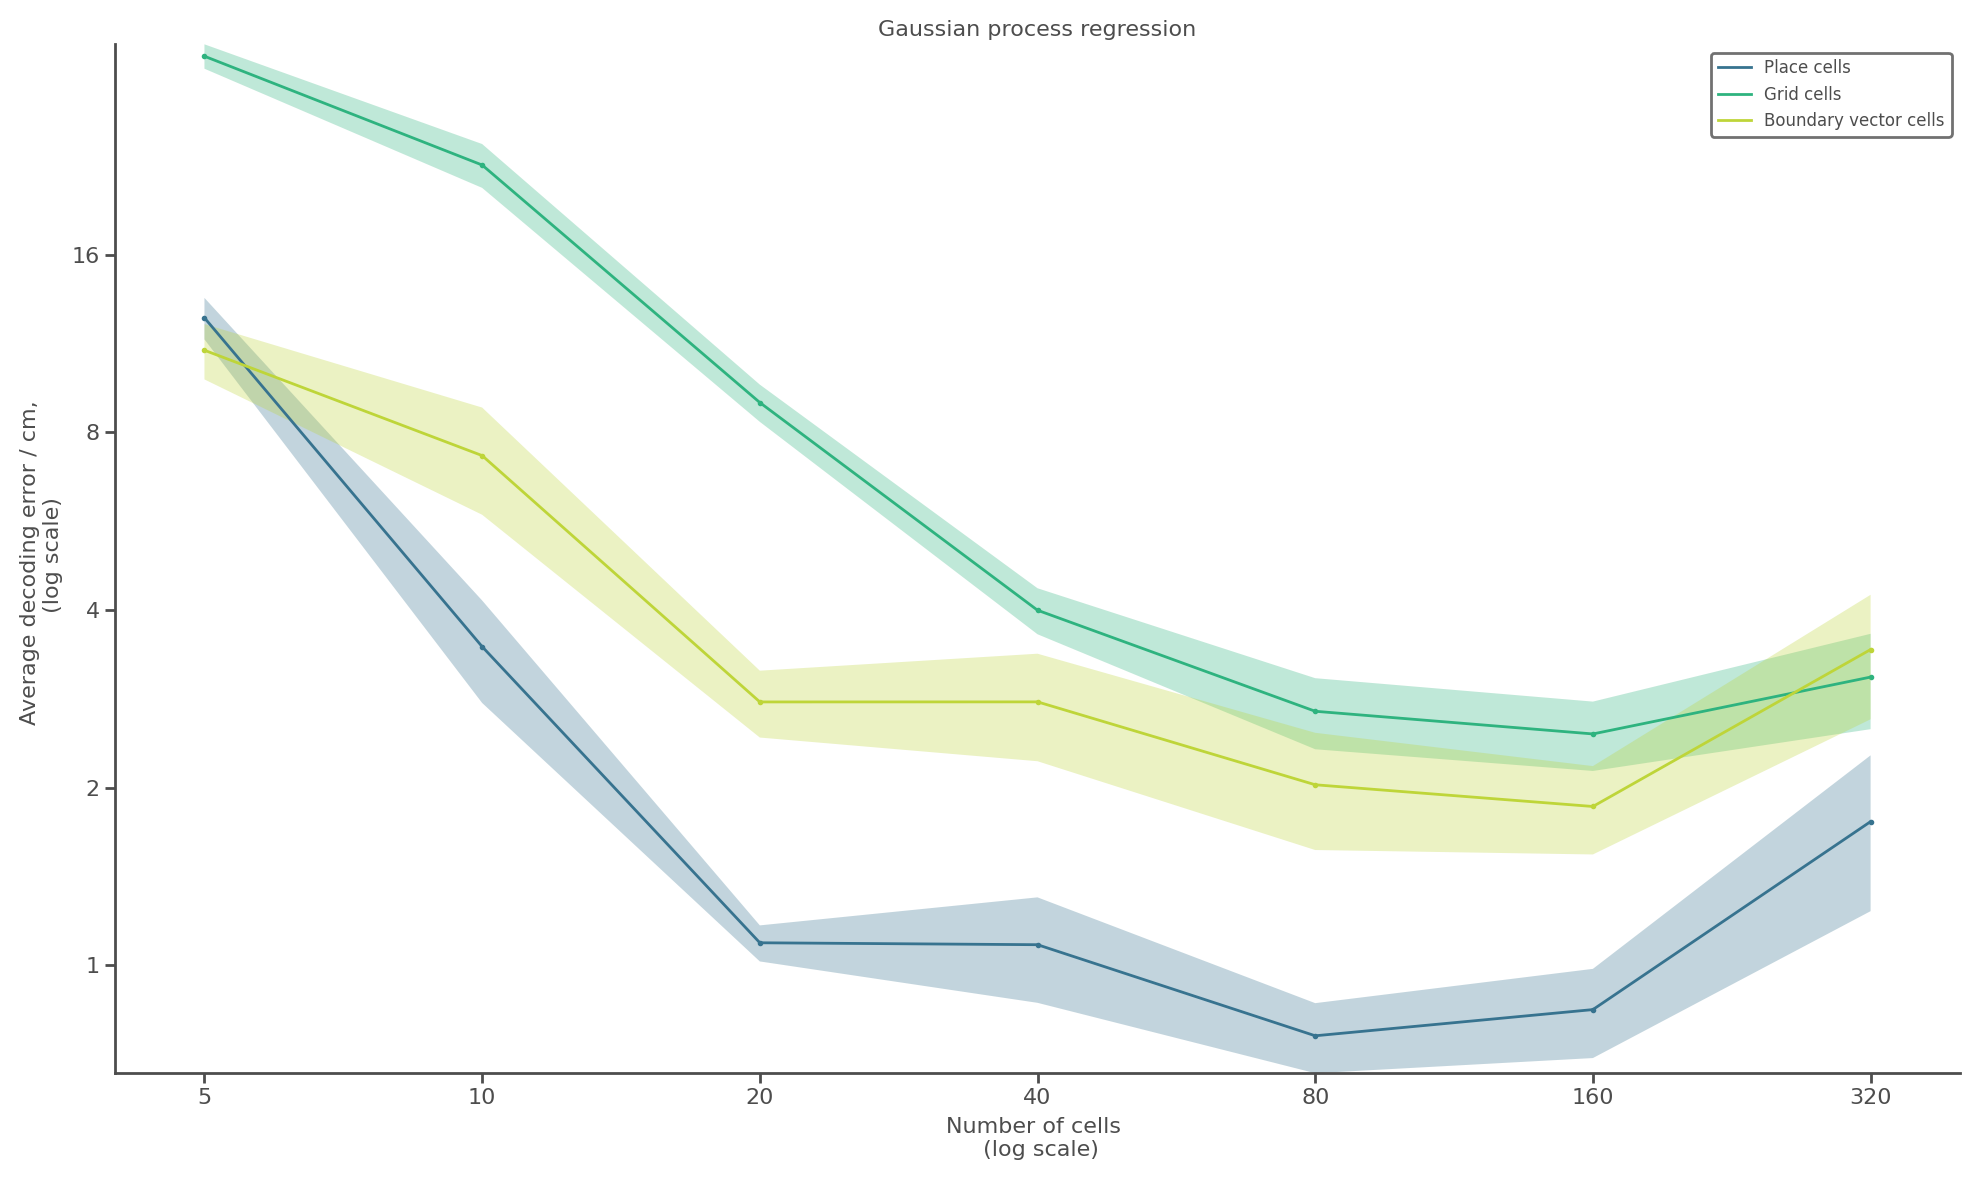

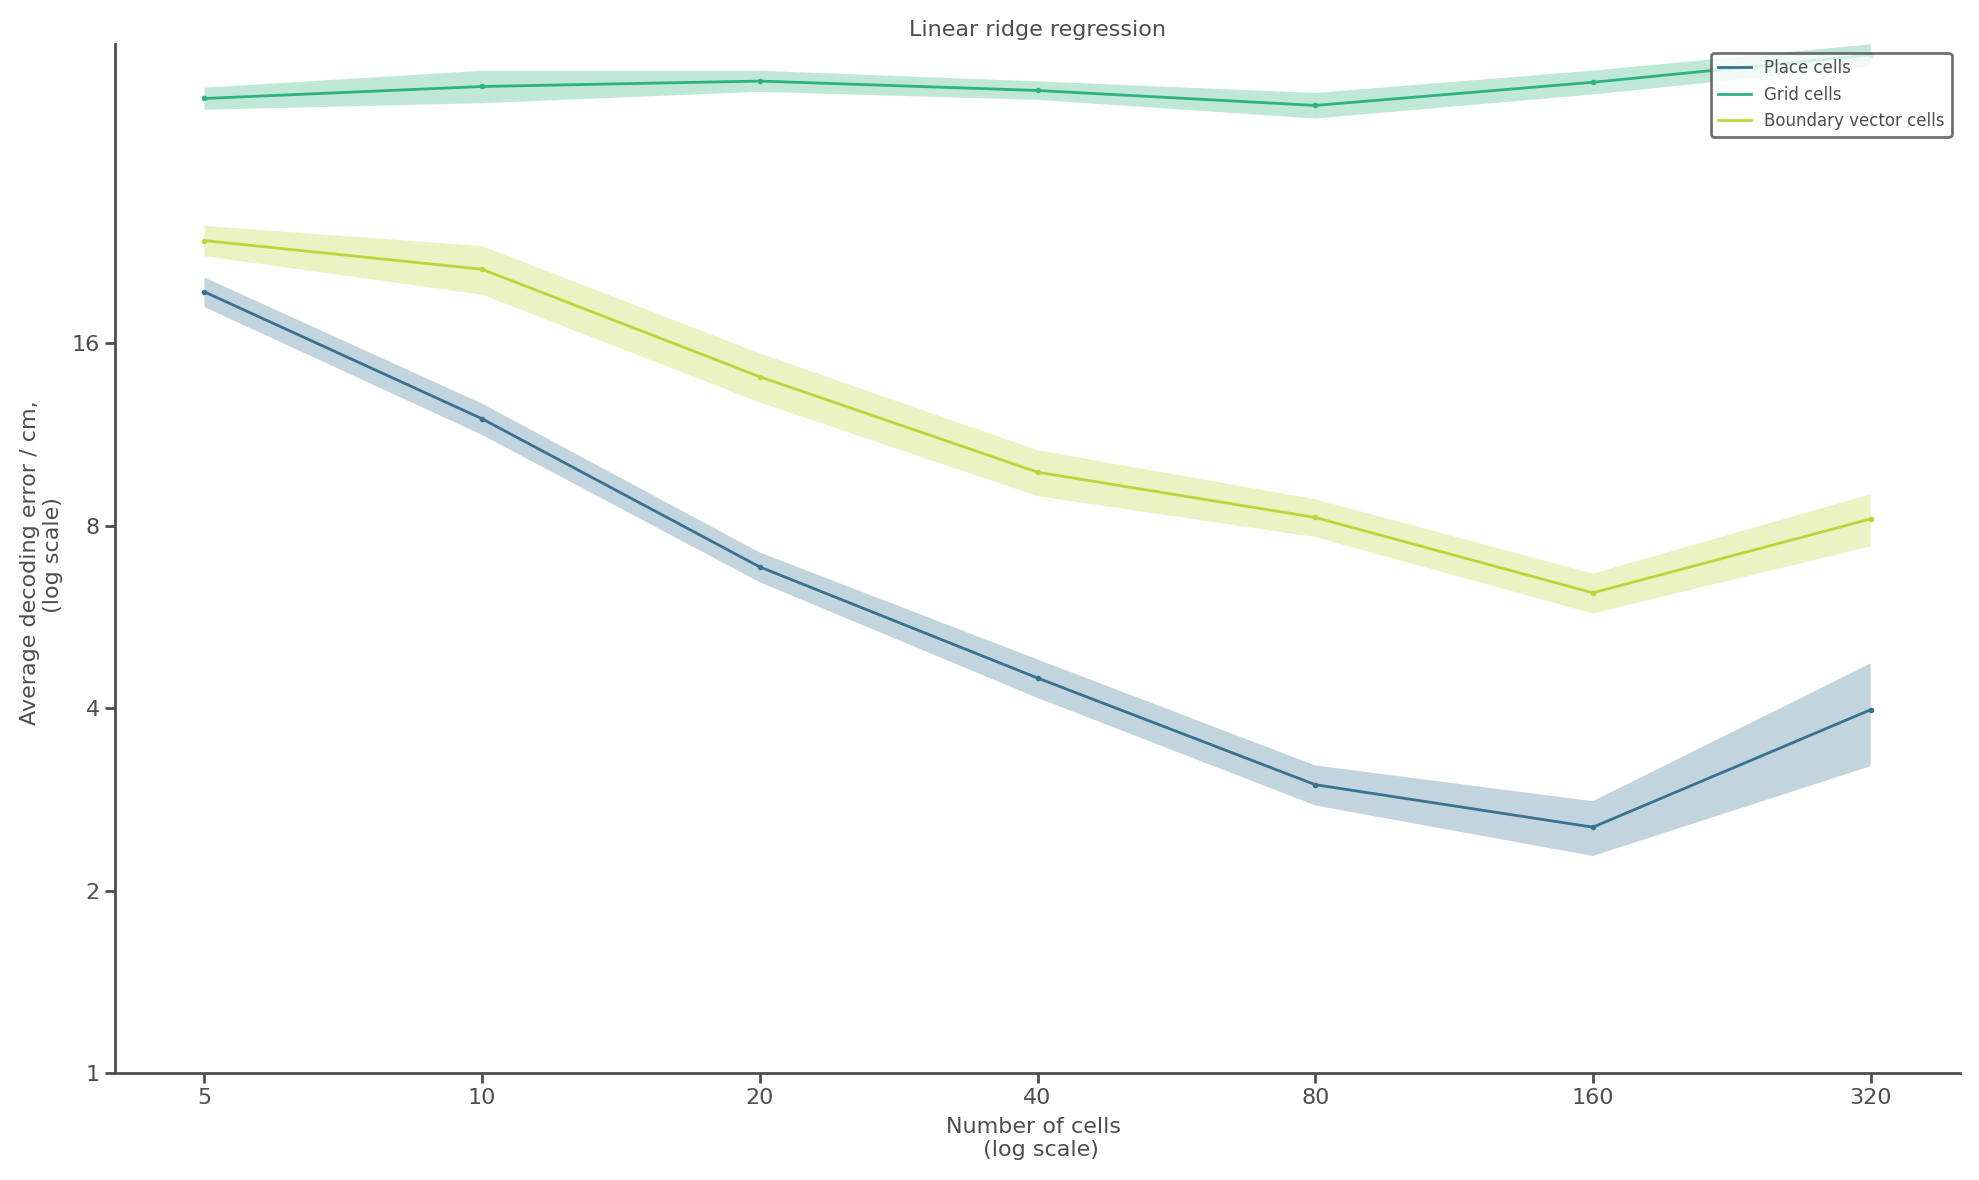

In [ ]:
# Get means and std from the results data frame
# 获取均值和标准差
means_GP = np.mean(results_array[:, :, :, 0], axis=2)
stds_GP = np.std(results_array[:, :, :, 0], axis=2) / np.sqrt(15)
means_LR = np.mean(results_array[:, :, :, 1], axis=2)
stds_LR = np.std(results_array[:, :, :, 1], axis=2) / np.sqrt(15)

# Make figure for Gaussian process regression
# 绘制高斯过程回归图
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(N_features, means_GP[0, :], c="C1")
ax.plot(N_features, means_GP[0, :], c="C1", label="Place cells", linewidth=1)
ax.fill_between(
    N_features,
    means_GP[0, :] + stds_GP[0, :],
    means_GP[0, :] - stds_GP[0, :],
    facecolor="C1",
    alpha=0.3,
)

ax.scatter(N_features, means_GP[1, :], c="C2")
ax.plot(N_features, means_GP[1, :], c="C2", label="Grid cells", linewidth=1)
ax.fill_between(
    N_features,
    means_GP[1, :] + stds_GP[1, :],
    means_GP[1, :] - stds_GP[1, :],
    facecolor="C2",
    alpha=0.3,
)

ax.scatter(N_features, means_GP[2, :], c="C3")
ax.plot(N_features, means_GP[2, :], c="C3", label="Boundary vector cells", linewidth=1)
ax.fill_between(
    N_features,
    means_GP[2, :] + stds_GP[2, :],
    means_GP[2, :] - stds_GP[2, :],
    facecolor="C3",
    alpha=0.3,
)

log2_cms = np.logspace(0, 4, 5, base=2, dtype=int)

ax.set_xlabel("Number of cells \n (log scale)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(axis="x", which="minor", bottom=False)
ax.tick_params(axis="y", which="minor", left=False)
ax.set_xbound(lower=N_features[-1] * 0.8, upper=N_features[0] / 0.8)
ax.set_ylabel("Average decoding error / cm, \n (log scale)")
ax.set_title("Gaussian process regression")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.set_xticks(N_features)
ax.set_yticks(log2_cms)
ax.set_xticklabels(N_features)
ax.set_yticklabels(log2_cms)
ax.legend(loc='upper right')
plt.tight_layout()


# Make identical figure for linear ridge regression
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(N_features, means_LR[0, :], c="C1")
ax.plot(N_features, means_LR[0, :], c="C1", label="Place cells", linewidth=1)
ax.fill_between(
    N_features,
    means_LR[0, :] + stds_LR[0, :],
    means_LR[0, :] - stds_LR[0, :],
    facecolor="C1",
    alpha=0.3,
)

ax.scatter(N_features, means_LR[1, :], c="C2")
ax.plot(N_features, means_LR[1, :], c="C2", label="Grid cells", linewidth=1)
ax.fill_between(
    N_features,
    means_LR[1, :] + stds_LR[1, :],
    means_LR[1, :] - stds_LR[1, :],
    facecolor="C2",
    alpha=0.3,
)

ax.scatter(N_features, means_LR[2, :], c="C3")
ax.plot(N_features, means_LR[2, :], c="C3", label="Boundary vector cells", linewidth=1)
ax.fill_between(
    N_features,
    means_LR[2, :] + stds_LR[2, :],
    means_LR[2, :] - stds_LR[2, :],
    facecolor="C3",
    alpha=0.3,
)

ax.set_xlabel("Number of cells \n (log scale)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(axis="x", which="minor", bottom=False)
ax.tick_params(axis="y", which="minor", left=False)
ax.set_xbound(lower=N_features[-1] * 0.8, upper=N_features[0] / 0.8)
ax.set_ylabel("Average decoding error / cm, \n (log scale)")
ax.set_title("Linear ridge regression")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.set_xticks(N_features)
ax.set_yticks(log2_cms)
ax.set_xticklabels(N_features)
ax.set_yticklabels(log2_cms)
ax.legend(loc='upper right')
plt.tight_layout()